In [2]:
# ------- Initialization and Setup -------
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

# Mount Google Drive (specific to Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Directory containing the dataset
data_dir = '/content/drive/MyDrive/Deep Learning/Data/images_original'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# ------- Data Preprocessing -------
# Collecting file paths and labels
file_paths = []
labels = []
for genre in genres:
    genre_dir = os.path.join(data_dir, genre)
    for file in os.listdir(genre_dir):
        file_paths.append(os.path.join(genre_dir, file))
        labels.append(genre)

# Shuffle and split data
file_paths = np.array(file_paths)
labels = np.array(labels)
indices = np.random.permutation(len(file_paths))
file_paths, labels = file_paths[indices], labels[indices]
train_files, val_files, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=2023
)

# Prepare DataFrames
train_df = pd.DataFrame({'file_path': train_files, 'label': train_labels})
val_df = pd.DataFrame({'file_path': val_files, 'label': val_labels})

# Image Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Setup generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(432, 288),
    batch_size=16,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='label',
    target_size=(432, 288),
    batch_size=16,
    class_mode='categorical'
)

# ------- Model Building -------
# Load and configure the MobileNetV2 model for transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(432, 288, 3))

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

# Add custom layers on top of MobileNetV2
inputs = base_model.input
x = base_model(inputs, training=True)  # Set to True to enable BatchNormalization layers to adapt
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)  # Increased dropout for regularization
x = Dense(256, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs, outputs)

# ------- Evaluation Metrics -------
# Initialize the optimizer using the legacy API
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

# Initialize metrics
precision_metric = Precision()
recall_metric = Recall()
auc_metric = AUC()

# Compile the model with the legacy optimizer and additional metrics
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', precision_metric, recall_metric, auc_metric])

# ------- Training -------
# Setup callbacks for model optimization
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)


Mounted at /content/drive
Found 799 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/200
50/50 [==============================] - 314s 6s/step - loss: 2.1475 - accuracy: 0.2253 - precision: 0.6596 - recall: 0.0388 - auc: 0.6743 - val_loss: 1.5884 - val_accuracy: 0.4650 - val_precision: 0.9310 - val_recall: 0.1350 - val_auc: 0.8664 - lr: 1.0000e-04
Epoch 2/200
50/50 [==============================] - 7s 136ms/step - loss: 1.4347 - accuracy: 0.5081 - precision: 0.7857 - recall: 0.2203 - auc: 0.8874 - val_loss: 1.2597 - val_accuracy: 0.5650 - val_precision: 0.8158 - val_recall: 0.3100 - val_auc: 0.9152 - lr: 1.0000e-04
Epoch 3/200
50/50 [==============================] - 7s 133ms/step - loss: 1.0183 - accuracy: 0.6721 - precision: 0.8635 - recall: 0.4355 - auc: 0.9468 - val_loss: 1.0458 - val_accuracy: 0.6300 - val_precision: 0.7913 - val_recall: 0.4550 - val_auc: 0.9379 - lr: 1.0000e-04
Epoch 4/200
50/50 [==============================] - 7s 131ms/step - loss: 0.7066 - accuracy: 0.7772 - precision: 0.

In [3]:
# Save model weights
model.save_weights('/content/drive/MyDrive/Deep Learning/model_weights_1.1.h5')

In [4]:
from tensorflow.keras.models import load_model

# Assuming the architecture of your model is already defined in 'model'
model.load_weights('/content/drive/MyDrive/Deep Learning/model_weights_1.1.h5')

In [5]:
# Evaluate the model on the validation set
results = model.evaluate(validation_generator)
print(f"Loss: {results[0]}, Accuracy: {results[1]}, Precision: {results[2]}, Recall: {results[3]}, AUC: {results[4]}")

13/13 [==============================] - 1s 99ms/step - loss: 0.8798 - accuracy: 0.7750 - precision: 0.8032 - recall: 0.7550 - auc: 0.9534
Loss: 0.8798187375068665, Accuracy: 0.7749999761581421, Precision: 0.8031914830207825, Recall: 0.7549999952316284, AUC: 0.9533777832984924


1/1 [==============================] - 0s 37ms/step


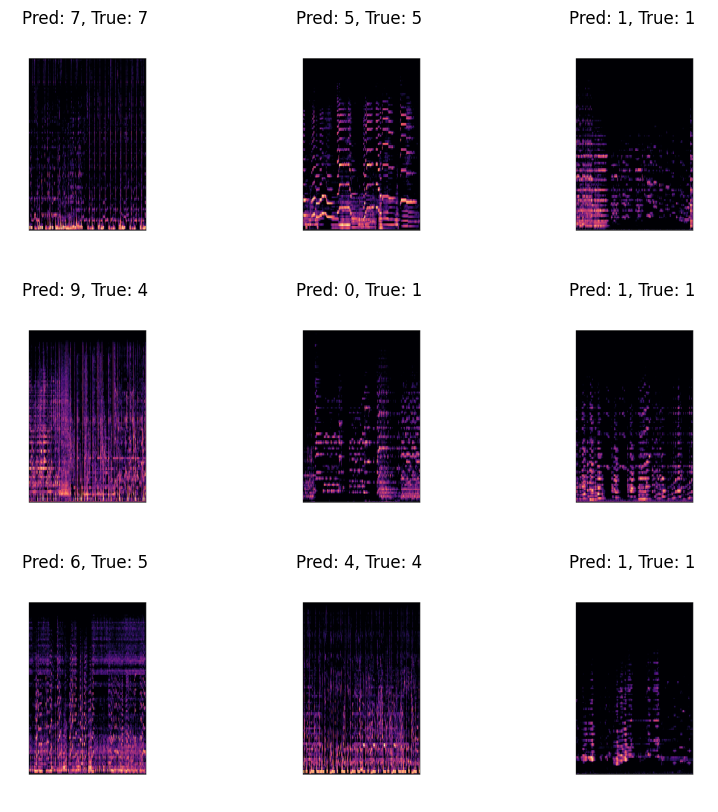

In [8]:
import matplotlib.pyplot as plt

# Making predictions on the first batch from the validation generator
for images, labels in validation_generator:
    predictions = model.predict(images)
    # Rescale images back to [0, 255] and convert type to uint8 for visualization
    images_display = (images * 255).astype('uint8')

    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display first 9 images in the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images_display[i])
        plt.title(f"Pred: {np.argmax(predictions[i])}, True: {np.argmax(labels[i])}")
        plt.axis("off")
    plt.show()
    break  # Only predict and show the first batch
